<a href="https://colab.research.google.com/github/ShrutiShetty10/Feature-Selection-using-WOA-in-CICIDIS-2018-dataset/blob/main/Feature_Selection_using_WOA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 pip install dask[dataframe]

     |████████████████████████████████| 125 kB 7.0 MB/s 


In [ ]:
pip install dask-ml

     |████████████████████████████████| 143 kB 8.6 MB/s 
     |████████████████████████████████| 23.1 MB 1.3 MB/s 
     |████████████████████████████████| 786 kB 34.2 MB/s 
     |████████████████████████████████| 779 kB 40.8 MB/s 
     |████████████████████████████████| 778 kB 43.9 MB/s 
     |████████████████████████████████| 776 kB 49.3 MB/s 
     |████████████████████████████████| 769 kB 76.1 MB/s 
     |████████████████████████████████| 766 kB 47.4 MB/s 
     |████████████████████████████████| 1.0 MB 37.4 MB/s 
     |████████████████████████████████| 722 kB 41.4 MB/s 
     |████████████████████████████████| 722 kB 46.4 MB/s 
     |████████████████████████████████| 715 kB 49.5 MB/s 
     |████████████████████████████████| 705 kB 60.0 MB/s 
     |████████████████████████████████| 699 kB 51.0 MB/s 
     |████████████████████████████████| 696 kB 47.2 MB/s 
     |████████████████████████████████| 684 kB 61.5 MB/s 
     |████████████████████████████████| 679 kB 33.2 MB/s 
     |█████████

In [ ]:
import dask.dataframe as dd
import numpy as np
from numba import jit

In [ ]:
data = dd.read_csv('/content/sample_data/02-21-2018.csv',assume_missing=True)
data.head()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80.0,6.0,21/02/2018 08:33:25,37953.0,5.0,3.0,135.0,127.0,135.0,0.0,27.0,60.373835,127.0,0.0,42.333333,73.323484,6903.275103,210.787026,5.421857e+03,5.403580e+03,12099.0,23.0,37953.0,9488.25,3.245485e+03,12382.0,6013.0,19960.0,9980.0,13546.75171,19559.0,401.0,0.0,0.0,0.0,0.0,168.0,104.0,131.741891,79.045135,0.0,135.0,29.111111,57.800183,3340.861111,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,32.750000,27.0,42.333333,0.0,0.0,0.0,0.0,0.0,0.0,5.0,135.0,3.0,127.0,29200.0,219.0,1.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1,500.0,17.0,21/02/2018 08:33:06,117573474.0,3.0,0.0,1500.0,0.0,500.0,500.0,500.0,0.000000,0.0,0.0,0.000000,0.000000,12.757980,0.025516,5.880000e+07,2.380000e+07,75600000.0,42000000.0,118000000.0,58800000.00,2.380000e+07,75600000.0,42000000.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.025516,0.000000,500.0,500.0,500.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,666.666667,500.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1500.0,0.0,0.0,-1.0,-1.0,2.0,8.0,0.0,0.0,0.0,0.0,58800000.0,23800000.0,75600000.0,42000000.0,Benign
2,500.0,17.0,21/02/2018 08:33:06,117573474.0,3.0,0.0,1500.0,0.0,500.0,500.0,500.0,0.000000,0.0,0.0,0.000000,0.000000,12.757980,0.025516,5.880000e+07,2.380000e+07,75600000.0,42000000.0,118000000.0,58800000.00,2.380000e+07,75600000.0,42000000.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.025516,0.000000,500.0,500.0,500.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,666.666667,500.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1500.0,0.0,0.0,-1.0,-1.0,2.0,8.0,0.0,0.0,0.0,0.0,58800000.0,23800000.0,75600000.0,42000000.0,Benign
3,500.0,17.0,21/02/2018 08:33:11,99743998.0,5.0,0.0,2500.0,0.0,500.0,500.0,500.0,0.000000,0.0,0.0,0.000000,0.000000,25.064165,0.050128,2.490000e+07,3.400000e+07,75600000.0,4000290.0,99700000.0,24900000.00,3.400000e+07,75600000.0,4000290.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,0.050128,0.000000,500.0,500.0,500.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,600.000000,500.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2500.0,0.0,0.0,-1.0,-1.0,4.0,8.0,4000290.0,0.0,4000290.0,4000290.0,31900000.0,37900000.0,75600000.0,7200397.0,Benign
4,500.0,17.0,21/02/2018 08:33:11,99743999.0,5.0,0.0,2500.0,0.0,500.0,500.0,500.0,0.000000,0.0,0.0,0.000000,0.000000,25.064165,0.050128,2.490000e+07,3.400000e+07,75600000.0,4000286.0,99700000.0,24900000.00,3.400000e+07,75600000.0,4000286.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,0.050128,0.000000,500.0,500.0,500.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,600.000000,500.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2500.0,0.0,0.0,-1.0,-1.0,4.0,8.0,4000286.0,0.0,4000286.0,4000286.0,31900000.0,37900000.0,75600000.0,7200399.0,Benign


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data.count(axis='columns')

Dask Series Structure:
npartitions=1
    int64
      ...
dtype: int64
Dask Name: dataframe-count, 4 tasks

In [ ]:
data.shape

(Delayed('int-988f24e9-2f42-4250-b0fb-32cdfc3d8596'), 80)

In [ ]:
data=data.drop('Timestamp',axis=1)

In [ ]:
data=data.replace([np.inf, -np.inf], np.nan)
data=data.dropna(how='any', subset=None, thresh=None)

In [ ]:
import numpy as np
from numpy.random import rand


In [ ]:
def init_position(lb, ub, N, dim):
    X = np.zeros([N, dim], dtype='float')
    for i in range(N):
        for d in range(dim):
            X[i,d] = lb[0,d] + (ub[0,d] - lb[0,d]) * rand()        
    
    return X

In [ ]:
def binary_conversion(X, thres, N, dim):
    Xbin = np.zeros([N, dim], dtype='int')
    for i in range(N):
        for d in range(dim):
            if X[i,d] > thres:
                Xbin[i,d] = 1
            else:
                Xbin[i,d] = 0
    
    return Xbin

In [ ]:
def boundary(x, lb, ub):
    if x < lb:
        x = lb
    if x > ub:
        x = ub
    
    return x

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# error rate
def error_rate(xtrain, ytrain, x, opts):
    # parameters
    k     = opts['k']
    fold  = opts['fold']
    xt    = fold['xt']
    yt    = fold['yt']
    xv    = fold['xv']
    yv    = fold['yv']
    
    # Number of instances
    num_train = np.size(xt, 0)
    num_valid = np.size(xv, 0)
    # Define selected features
    xtrain  = xt[:, x == 1]
    ytrain  = yt.reshape(num_train)  # Solve bug
    xvalid  = xv[:, x == 1]
    yvalid  = yv.reshape(num_valid)  # Solve bug   
    # Training
    mdl     = KNeighborsClassifier(n_neighbors = k)
    mdl.fit(xtrain, ytrain)
    # Prediction
    ypred   = mdl.predict(xvalid)
    acc     = np.sum(yvalid == ypred) / num_valid
    error   = 1 - acc
    return error

In [ ]:
# Error rate & Feature size
def Fun(xtrain, ytrain, x, opts):
    # Parameters
    alpha    = 0.99
    beta     = 1 - alpha
    # Original feature size
    max_feat = len(x)
    # Number of selected features
    num_feat = np.sum(x == 1)
    # Solve if no feature selected
    if num_feat == 0:
        cost  = 1
    else:
        # Get error rate
        error = error_rate(xtrain, ytrain, x, opts)
        # Objective function
        cost  = alpha * error + beta * (num_feat / max_feat)
        
    return cost

In [ ]:
@jit
def jfs(xtrain, ytrain, opts):
    # Parameters
    ub    = 1
    lb    = 0
    thres = 0.5
    b     = 1       # constant
    
    N        = opts['N']
    max_iter = opts['T']
    if 'b' in opts:
        b    = opts['b']
    
    # Dimension
    dim = np.size(xtrain, 1)
    if np.size(lb) == 1:
        ub = ub * np.ones([1, dim], dtype='float')
        lb = lb * np.ones([1, dim], dtype='float')
        
    # Initialize position 
    X    = init_position(lb, ub, N, dim)
    
    # Binary conversion
    Xbin = binary_conversion(X, thres, N, dim)
    
    # Fitness at first iteration
    fit  = np.zeros([N, 1], dtype='float')
    Xgb  = np.zeros([1, dim], dtype='float')
    fitG = float('inf')
    
    for i in range(N):
        fit[i,0] = Fun(xtrain, ytrain, Xbin[i,:], opts)
        if fit[i,0] < fitG:
            Xgb[0,:] = X[i,:]
            fitG     = fit[i,0]
        
    # Pre
    curve = np.zeros([1, max_iter], dtype='float') 
    t     = 0
    
    curve[0,t] = fitG.copy()
    print("Generation:", t + 1)
    print("Best (WOA):", curve[0,t])
    t += 1

    while t < max_iter:
        # Define a, linearly decreases from 2 to 0 
        a = 2 - t * (2 / max_iter)
        
        for i in range(N):
            # Parameter A (2.3)
            A = 2 * a * rand() - a
            # Paramater C (2.4)
            C = 2 * rand()
            # Parameter p, random number in [0,1]
            p = rand()
            # Parameter l, random number in [-1,1]
            l = -1 + 2 * rand()  
            # Whale position update (2.6)
            if p  < 0.5:
                # {1} Encircling prey
                if abs(A) < 1:
                    for d in range(dim):
                        # Compute D (2.1)
                        Dx     = abs(C * Xgb[0,d] - X[i,d])
                        # Position update (2.2)
                        X[i,d] = Xgb[0,d] - A * Dx
                        # Boundary
                        X[i,d] = boundary(X[i,d], lb[0,d], ub[0,d])
                
                # {2} Search for prey
                elif abs(A) >= 1:
                    for d in range(dim):
                        # Select a random whale
                        k      = np.random.randint(low = 0, high = N)
                        # Compute D (2.7)
                        Dx     = abs(C * X[k,d] - X[i,d])
                        # Position update (2.8)
                        X[i,d] = X[k,d] - A * Dx
                        # Boundary
                        X[i,d] = boundary(X[i,d], lb[0,d], ub[0,d])
            
            # {3} Bubble-net attacking 
            elif p >= 0.5:
                for d in range(dim):
                    # Distance of whale to prey
                    dist   = abs(Xgb[0,d] - X[i,d])
                    # Position update (2.5)
                    X[i,d] = dist * np.exp(b * l) * np.cos(2 * np.pi * l) + Xgb[0,d] 
                    # Boundary
                    X[i,d] = boundary(X[i,d], lb[0,d], ub[0,d])
        
        # Binary conversion
        Xbin = binary_conversion(X, thres, N, dim)
        
        # Fitness
        for i in range(N):
            fit[i,0] = Fun(xtrain, ytrain, Xbin[i,:], opts)
            if fit[i,0] < fitG:
                Xgb[0,:] = X[i,:]
                fitG     = fit[i,0]
        
        # Store result
        curve[0,t] = fitG.copy()
        print("Generation:", t + 1)
        print("Best (WOA):", curve[0,t])
        t += 1            

            
    # Best feature subset
    Gbin       = binary_conversion(Xgb, thres, 1, dim) 
    Gbin       = Gbin.reshape(dim)    
    pos        = np.asarray(range(0, dim))    
    sel_index  = pos[Gbin == 1]
    num_feat   = len(sel_index)
    # Create dictionary
    woa_data = {'sf': sel_index, 'c': curve, 'nf': num_feat}
    
    return woa_data 

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
feat  = np.asarray(data.iloc[:, 0:-1])
label = np.asarray(data.iloc[:, -1])

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(feat, label, test_size=0.3, stratify=label)
fold = {'xt':xtrain, 'yt':ytrain, 'xv':xtest, 'yv':ytest}

In [ ]:
k    = 5     # k-value in KNN
N    = 10    # number of particles
T    = 25   # maximum number of iterations
opts = {'k':k, 'fold':fold, 'N':N, 'T':T}


In [ ]:
fmdl = jfs(feat, label, opts)

<ipython-input-27-56437ea758b0>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "jfs" failed type inference due to: Untyped global name 'init_position': cannot determine Numba type of <class 'function'>

File "<ipython-input-27-56437ea758b0>", line 21:
def jfs(xtrain, ytrain, opts):
    <source elided>
    # Initialize position 
    X    = init_position(lb, ub, N, dim)
    ^

  @jit
<ipython-input-27-56437ea758b0>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "jfs" failed type inference due to: Untyped global name 'init_position': cannot determine Numba type of <class 'function'>

File "<ipython-input-27-56437ea758b0>", line 21:
def jfs(xtrain, ytrain, opts):
    <source elided>
    # Initialize position 
    X    = init_position(lb, ub, N, dim)
    ^

  @jit
/usr/local/lib/python3.7/dist-packages/numba/core/object_mode_passes.py:178: NumbaWarning: Function "jfs" was compi

Generation: 1
Best (WOA): 0.0041178006246499295


<ipython-input-27-56437ea758b0>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "jfs" failed type inference due to: Untyped global name 'boundary': cannot determine Numba type of <class 'function'>

File "<ipython-input-27-56437ea758b0>", line 69:
def jfs(xtrain, ytrain, opts):
    <source elided>
                        # Boundary
                        X[i,d] = boundary(X[i,d], lb[0,d], ub[0,d])
                        ^

  @jit
/usr/local/lib/python3.7/dist-packages/numba/core/object_mode_passes.py:178: NumbaWarning: Function "jfs" was compiled in object mode without forceobj=True.

File "<ipython-input-27-56437ea758b0>", line 46:
def jfs(xtrain, ytrain, opts):
    <source elided>

    while t < max_iter:
    ^

  state.func_ir.loc))
/usr/local/lib/python3.7/dist-packages/numba/core/object_mode_passes.py:188: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been d

Generation: 2
Best (WOA): 0.003058838606783866
Generation: 3
Best (WOA): 0.0019998765889176935
Generation: 4
Best (WOA): 0.0019998765889176935
Generation: 5
Best (WOA): 0.0019998765889176935
Generation: 6
Best (WOA): 0.0016203400449975465
Generation: 7
Best (WOA): 0.0016203400449975465
Generation: 8
Best (WOA): 0.0016203400449975465
Generation: 9
Best (WOA): 0.00136392978858729
Generation: 10
Best (WOA): 0.00136392978858729
Generation: 11
Best (WOA): 0.0012357246603821616
Generation: 12
Best (WOA): 0.0012357246603821616
Generation: 13
Best (WOA): 0.0012357246603821616
Generation: 14
Best (WOA): 0.0012357246603821616
Generation: 15
Best (WOA): 0.0010075565555018135
Generation: 16
Best (WOA): 0.0010075565555018135
Generation: 17
Best (WOA): 0.0010075565555018135
Generation: 18
Best (WOA): 0.0010075565555018135
Generation: 19
Best (WOA): 0.0010075565555018135
Generation: 20
Best (WOA): 0.0010075565555018135
Generation: 21
Best (WOA): 0.0010075565555018135
Generation: 22
Best (WOA): 0.0010

[30 40 63 67 76]
Accuracy: 99.96297667530544
Feature Size: 5


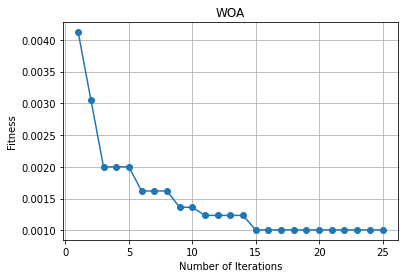

In [ ]:
sf   = fmdl['sf']
print(sf)
# model with selected features
num_train = np.size(xtrain, 0)
num_valid = np.size(xtest, 0)
x_train   = xtrain[:, sf]
y_train   = ytrain.reshape(num_train)  # Solve bug
x_valid   = xtest[:, sf]
y_valid   = ytest.reshape(num_valid)  # Solve bug

mdl       = KNeighborsClassifier(n_neighbors = k) 
mdl.fit(x_train, y_train)

# accuracy
y_pred    = mdl.predict(x_valid)
Acc       = np.sum(y_valid == y_pred)  / num_valid
print("Accuracy:", 100 * Acc)

# number of selected features
num_feat = fmdl['nf']
print("Feature Size:", num_feat)

# plot convergence
curve   = fmdl['c']
curve   = curve.reshape(np.size(curve,1))
x       = np.arange(0, opts['T'], 1.0) + 1.0

fig, ax = plt.subplots()
ax.plot(x, curve, 'o-')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('WOA')
ax.grid()
plt.show()

In [ ]:
pip install seaborn

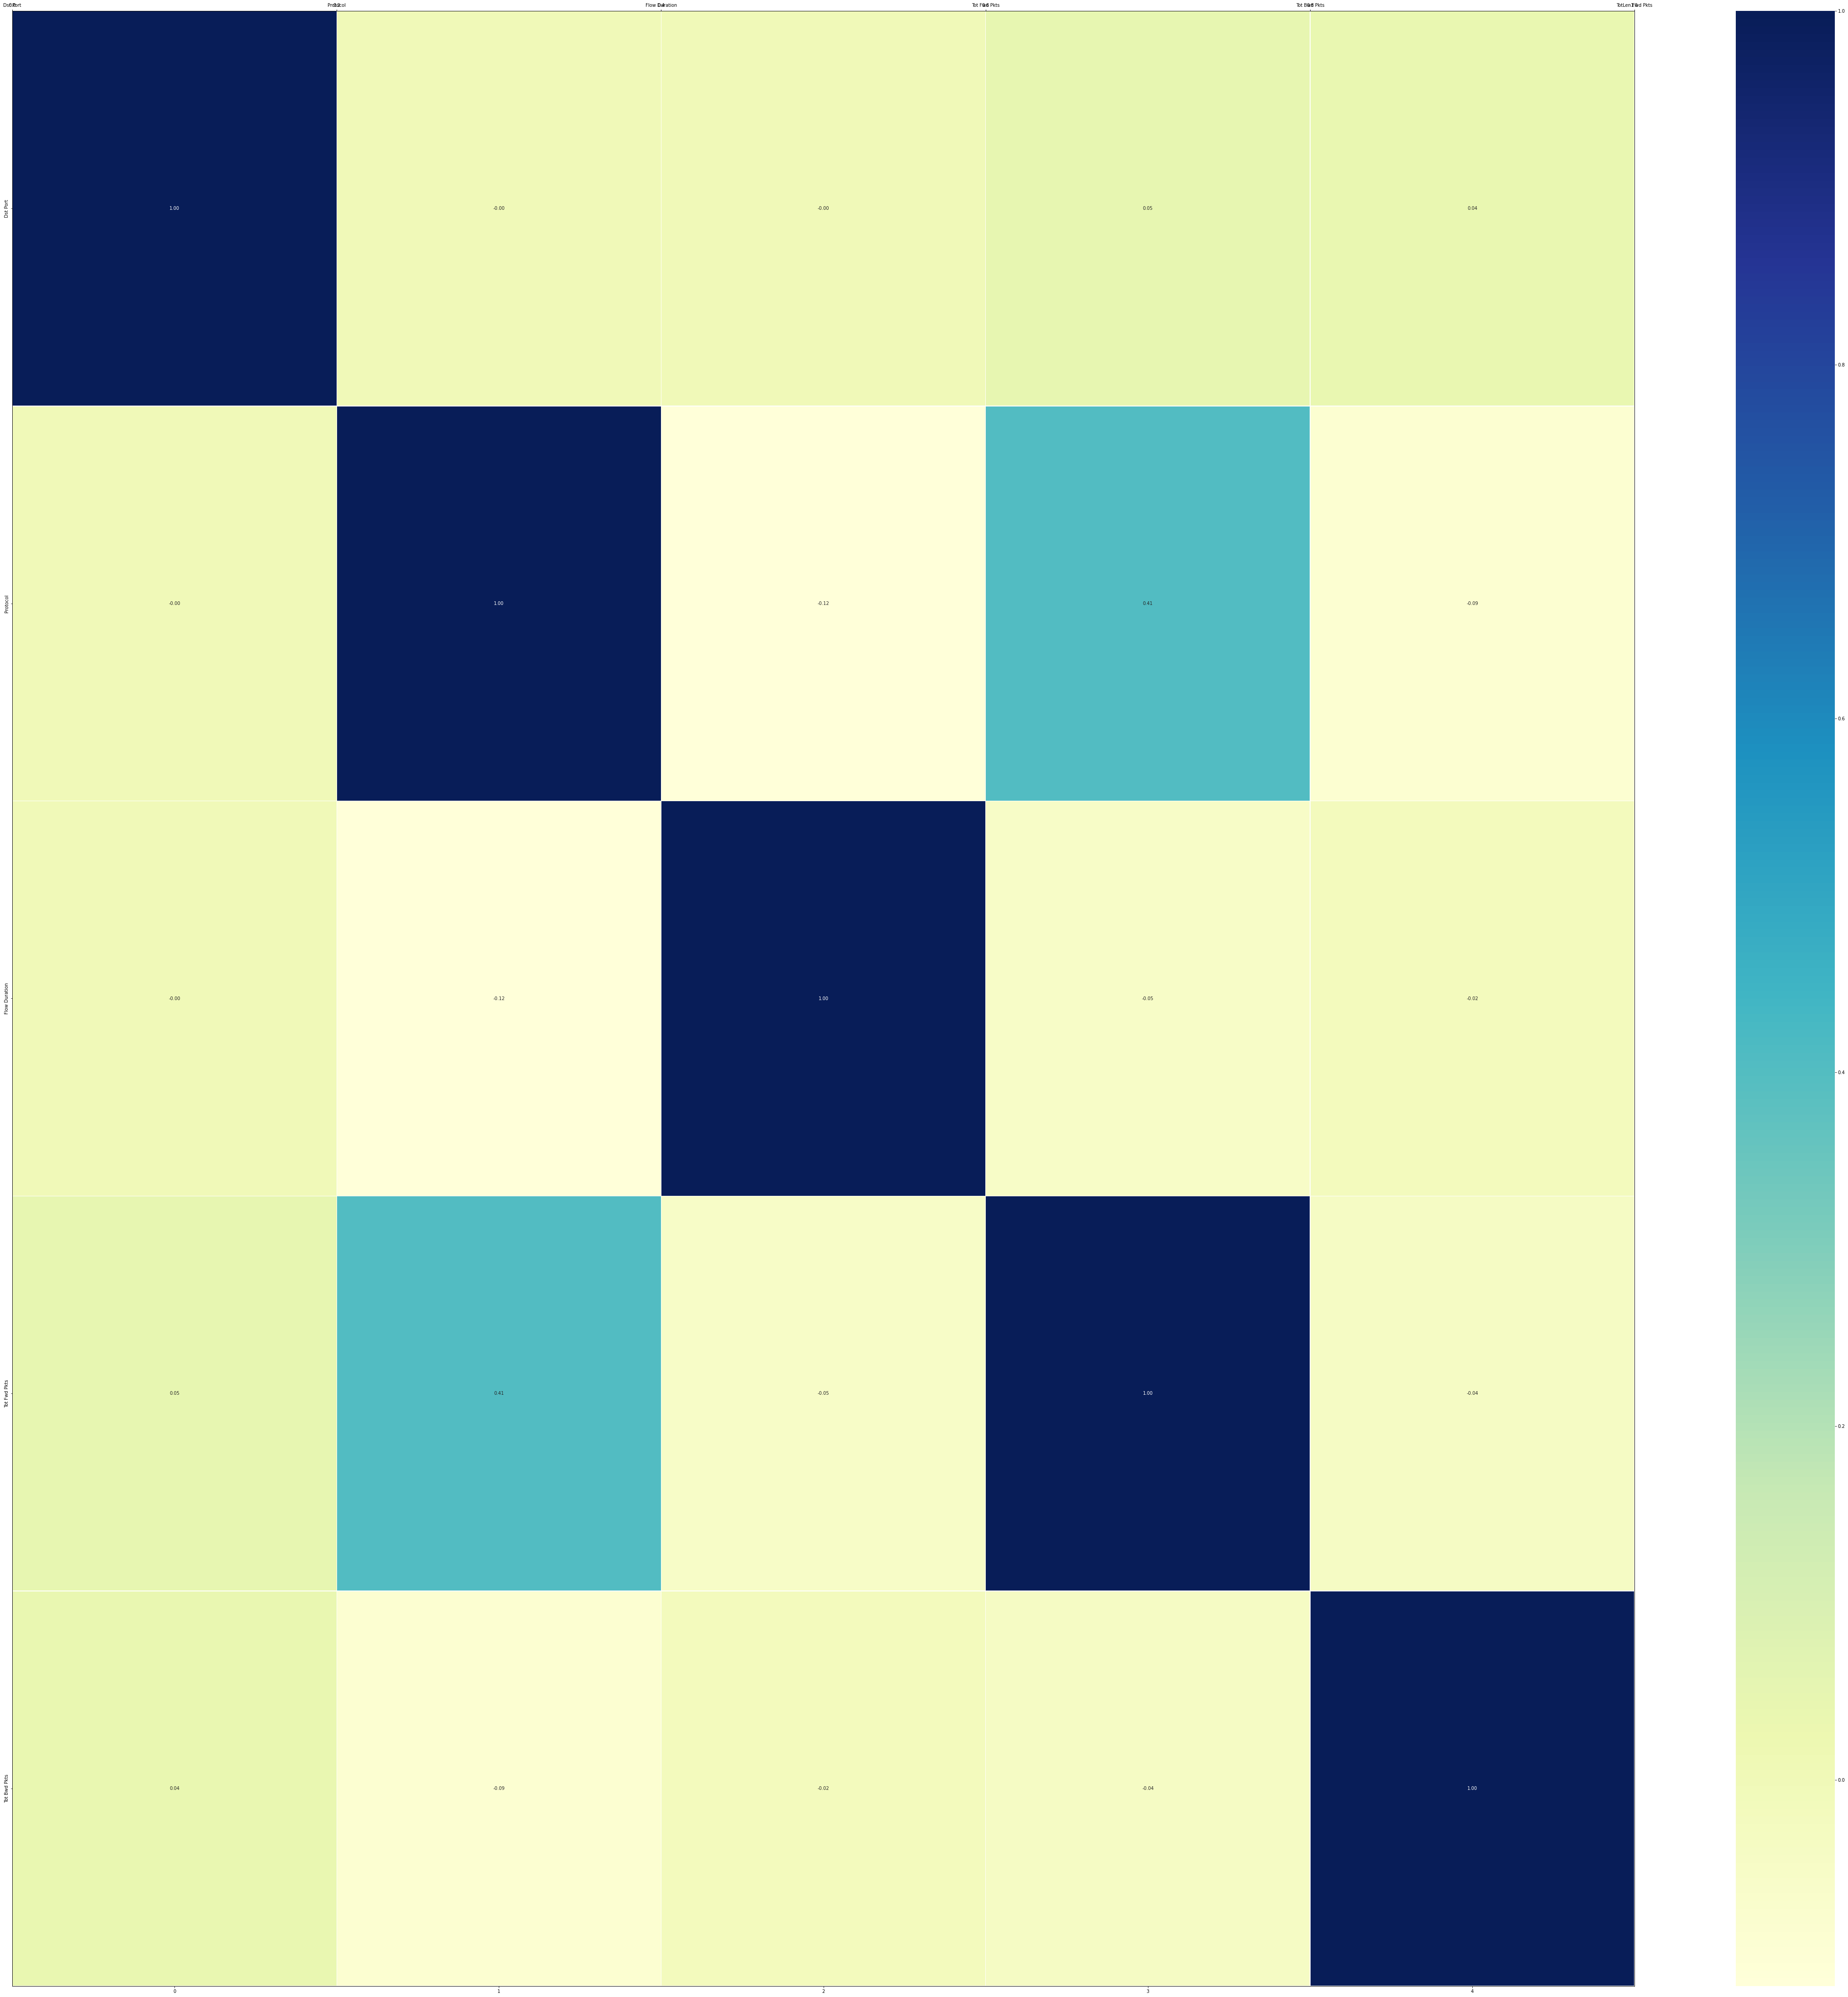

In [ ]:
import seaborn as sb
import matplotlib.pyplot as mp
# plotting correlation heatmap

fig, ax = mp.subplots(figsize=(80,80))
dataplot = sb.heatmap(selected_data.corr(), cmap="YlGnBu", annot=True,linewidths=.5,ax=ax, fmt= '.2f')
ax3 = ax.twiny()
ax4 = ax.twiny()
ax3.set_xticklabels(data.columns.tolist())
ax4.set_yticklabels(data.columns.tolist())
# displaying heatmap
mp.show()
figure = dataplot.get_figure()    
figure.savefig('heatmap.png', dpi=150)

In [ ]:
import pandas as pd
selected_data=data[[data.columns[30],data.columns[40],data.columns[63],data.columns[67],data.columns[76],data.columns[78]]].copy()
#df_final = selected_data.apply(dd.to_numeric,axis=1,arg=(5,))
#from sklearn.preprocessing import LabelEncoder
#
# Instantiate LabelEncoder
#
#le = LabelEncoder()
#
# Encode single column status
#
print(selected_data.head())
#selected_data["Label"] = le.fit_transform(selected_data['Label'])
#
# Print df.head for checking the transformation
#



   Bwd IAT Min  Pkt Len Max  ...    Idle Max   Label
0        401.0        135.0  ...         0.0  Benign
1          0.0        500.0  ...  75600000.0  Benign
2          0.0        500.0  ...  75600000.0  Benign
3          0.0        500.0  ...  75600000.0  Benign
4          0.0        500.0  ...  75600000.0  Benign

[5 rows x 6 columns]


In [ ]:
print(data.columns[30],data.columns[40],data.columns[63],data.columns[67],data.columns[76])



Bwd IAT Min Pkt Len Max Subflow Fwd Byts Init Bwd Win Byts Idle Max
